In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from collections import Counter
from preprocessing.build_dataset import get_dataset_splits
from preprocessing.build_dataset import LABELS
from preprocessing.SongsDataset import SongsDataset
from preprocessing.TokenizeTransformer import TokenizeTransformer
from preprocessing.RemoveStopwordsTransform import RemoveStopwordsTransform
from preprocessing.RemovePunctuationTransformer import RemovePunctuationTransformer
from torchvision import transforms
from torch.utils.data import DataLoader
from nltk.tokenize import word_tokenize
import numpy as np
import time

X_train, y_train, X_val, y_val, X_test, y_test = get_dataset_splits("english_cleaned_lyrics.csv", train_size_p=0.8, val_size_p=0.1)



'''
train_dataset = SongsDataset(
	X_train, 
	y_train, 
	transform=transforms.Compose([RemovePunctuationTransformer()])
)

print(len(train_dataset))
for i, (x, y) in enumerate(train_dataset):
	print(x, y)
	break
'''
	

# for i, x, y in enumerate(train_dataset):
# 	# print(x, y)
# 	# break
# 	print(i + 1)
# 	pass

# BATCH_SIZE = 16
# train_loader = DataLoader(
# 	train_dataset,
# 	batch_size=BATCH_SIZE,
# 	shuffle=True,
# )

# for X, y in train_loader:
# 	break

'\ntrain_dataset = SongsDataset(\n\tX_train, \n\ty_train, \n\ttransform=transforms.Compose([RemovePunctuationTransformer()])\n)\n\nprint(len(train_dataset))\nfor i, (x, y) in enumerate(train_dataset):\n\tprint(x, y)\n\tbreak\n'

In [2]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def max_freq_of_class(X_train, y_train, max_freq):
    X_ret = []
    y_ret = []
    freq = 4 * [0]
    
    for i in range(len(X_train)):
        if freq[y_train[i]] < max_freq:
            freq[y_train[i]] += 1
            X_ret.append(X_train[i])
            y_ret.append(y_train[i])
    return X_ret, y_ret

In [4]:
print(Counter(y_train))

Counter({3: 70932, 2: 24773, 0: 16604, 1: 16299})


In [5]:
X_train, y_train = max_freq_of_class(X_train, y_train, 16299)

In [6]:
remove_punctuation = RemovePunctuationTransformer()
X_train = remove_punctuation(X_train)

print(X_train[0:2])

['The pain the pain of a broken heart The price Ill pay for loving you I loved you from the very start But Ill get over losing you I just cant seem to realize Youre leaving me today As burning teardrops fill my eyes I watch you walk away The pain the pain of a broken heart The price Ill pay for loving you I loved you from the very start But Ill get over losing you I lost my love I lost my home I just cant seem to win If I get over losing you Ill never love again'
 ' You aint never had a thug You aint never had a thug Beat it all night til you had enough You aint never had a thug Buss it down for a cup Best friend said she only want a blood You aint never had a thug Wait wait a minute Wait wait a minute You aint never had a thug Wait wait a minute Wait wait a minute You aint never had a thug You aint never had a thug Tired of these lame ass niggas in the club I aint here to play games I aint lookin for the love Let your man date you Im the one to beat it up Do it tll it hurts on the tur

In [7]:
def tokenize(string):
    return [x.lower() for x in string.split()]
tokenizer = TokenizeTransformer(tokenize)
X_train_tokenized = tokenizer(X_train)
X_val_tokenized = tokenizer(X_val)
X_test_tokenized = tokenizer(X_test)

In [8]:
X_train_no_stop_words = []
stop_word_remover = RemoveStopwordsTransform()
for x in X_train_tokenized:
    X_train_no_stop_words.append(stop_word_remover(x))
X_train_tokenized = []
X_val_no_stop_words = [stop_word_remover(x) for x in X_val_tokenized]
X_val_tokenized = []
X_test_no_stop_words = [stop_word_remover(x) for x in X_test_tokenized]

In [9]:
distinct_tokens = {}
for x in X_train_no_stop_words:
    for token in x:
        if token in distinct_tokens.keys():
            distinct_tokens[token] += 1
        else:
            distinct_tokens[token] = 1


In [10]:
relevant_tokens = [token for token, frequency in distinct_tokens.items() if frequency >= 10]

In [11]:
input_size = len(relevant_tokens)
print(input_size)

27624


In [12]:
print(len(X_train_no_stop_words))

65196


In [13]:
print(DEVICE)

cuda


In [14]:
# X_train = []
# cnt_zeros = 0
# from collections import Counter
# import math
# for x in X_train_no_stop_words:
#     xx = x.tolist()
#     freq = Counter(xx)
#     bow = []

#     for token in relevant_tokens:
#         try:
#             bow.append(freq[token])
#         except:
#             bow.append(0)
#     bow = np.array(bow)
#     if(np.amax(bow) != 0):
#         bow = bow / np.amax(bow)
#     if np.count_nonzero(bow) == 0:
#         cnt_zeros += 1
#     X_train.append(bow)

# print(cnt_zeros)


In [15]:
train_dataset = SongsDataset(
	X_train, 
	y_train,
    device=DEVICE 
)


In [16]:
X_val = []
for x in X_val_no_stop_words:
    xx = x.tolist()
    freq = Counter(xx)
    bow = []

    for token in relevant_tokens:
        try:
            bow.append(freq[token])
        except:
            bow.append(0)
    bow = np.array(bow)
    if(np.amax(bow) != 0):
        bow = bow / np.amax(bow)
    X_val.append(bow)
print(X_val[:2])


[array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])]


In [17]:
X_val, y_val = max_freq_of_class(X_val, y_val, 2038)

In [18]:
print(len(X_val), len(y_val))

8152 8152


In [19]:
X_test = []
for x in X_test_no_stop_words:
    xx = x.tolist()
    freq = Counter(xx)
    bow = []

    for token in relevant_tokens:
        try:
            bow.append(freq[token])
        except:
            bow.append(0)
    bow = np.array(bow)
    if(np.amax(bow) != 0):
        bow = bow / np.amax(bow)
    X_test.append(bow)
print(X_test[:2])

[array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])]


In [20]:
validate_dataset = SongsDataset(
	X_val,
	y_val
)

In [21]:
test_dataset = SongsDataset (
    X_test,
    y_test
)

In [22]:

from torch import nn
from torch import optim
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
validate_dataloader = torch.utils.data.DataLoader(validate_dataset, batch_size=64, shuffle=True)

In [23]:

model = nn.Sequential(
    nn.Linear(input_size, 1024).to(DEVICE),
    nn.ReLU().to(DEVICE),
    nn.Linear(1024, 1024).to(DEVICE),
    nn.ReLU().to(DEVICE),
    nn.Linear(1024, 4).to(DEVICE),
    nn.Softmax(dim=1).to(DEVICE)
).to(DEVICE)


In [24]:
# optimiser = optim.SGD(model.parameters(), lr = 1e-2, momentum=0.9)

In [25]:
loss_fn = nn.CrossEntropyLoss()
print(DEVICE)

cuda


In [26]:
print(Counter(y_train))

Counter({3: 16299, 0: 16299, 1: 16299, 2: 16299})


In [27]:
# cnt_epochs = 25
# import sklearn.metrics as metrics
# def epoch():
#     model.train()
#     for (vectors, labels) in train_dataloader:
#         vectors = vectors.type(torch.FloatTensor)
#         vectors = vectors.to(DEVICE)
        
#         labels = labels.type(torch.LongTensor)
#         labels = labels.to(DEVICE)

#         optimiser.zero_grad()

#         output = model(vectors)
        
#         loss = loss_fn(output, labels)

#         loss.backward()

#         optimiser.step()

# def check(dataloader):
#     model.eval()

#     true_labels = []
#     predicted_labels = []
#     mean_loss = 0

#     with torch.no_grad():
#         for (vectors, labels) in dataloader:
#             vectors = vectors.type(torch.FloatTensor)
#             vectors = vectors.to(DEVICE)
            
#             labels = labels.type(torch.LongTensor)
#             labels = labels.to(DEVICE)

#             output = model(vectors)
#             loss = loss_fn(output, labels)

#             mean_loss += loss.item()
#             true_labels.extend(labels.tolist())
#             last = output
#             predicted_labels.extend(output.detach().argmax(dim=1).tolist())
#     #print(last[0:2])
#     return mean_loss, metrics.accuracy_score(true_labels, predicted_labels)

# for i in range(cnt_epochs):
#     if i % 5 == 0:
#         for g in optimiser.param_groups:
#             g['lr'] = (10 - 2 * (i / 5)) * 1e-3
#         curr_lr = (10 - 2 * (i / 5)) * 1e-3
#     epoch()
#     mean_loss_train, accuracy_train = check(train_dataloader)
#     mean_loss, accuracy = check(validate_dataloader)
#     print(f"Epoca {i}, lr = {curr_lr} Mean Loss = {mean_loss}, Accuracy = {accuracy}, Mean Loss Train = {mean_loss_train}, Accuracy Train = {accuracy_train}, ")


In [28]:
#torch.save(model.state_dict(), "E:\work\Machine Learning\lyrics-classification-songs\model")

In [29]:

model.load_state_dict(torch.load("E:\work\Machine Learning\lyrics-classification-songs\model_bogdan"))
model.eval()

Sequential(
  (0): Linear(in_features=27624, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=4, bias=True)
  (5): Softmax(dim=1)
)

In [30]:
import sklearn.metrics as metrics
def check(dataloader):
    model.eval()

    true_labels = []
    predicted_labels = []
    mean_loss = 0

    with torch.no_grad():
        for (vectors, labels) in dataloader:
            vectors = vectors.type(torch.FloatTensor)
            vectors = vectors.to(DEVICE)
            
            labels = labels.type(torch.LongTensor)
            labels = labels.to(DEVICE)

            output = model(vectors)
            loss = loss_fn(output, labels)

            mean_loss += loss.item()
            true_labels.extend(labels.tolist())
            last = output
            predicted_labels.extend(output.detach().argmax(dim=1).tolist())
    #print(last[0:2])
    return mean_loss, metrics.accuracy_score(true_labels, predicted_labels), metrics.confusion_matrix(true_labels, predicted_labels), metrics.precision_recall_fscore_support(true_labels, predicted_labels)

In [31]:
mean_loss, accuracy, conf_matrix, prfs = check(test_dataloader)

<AxesSubplot:>

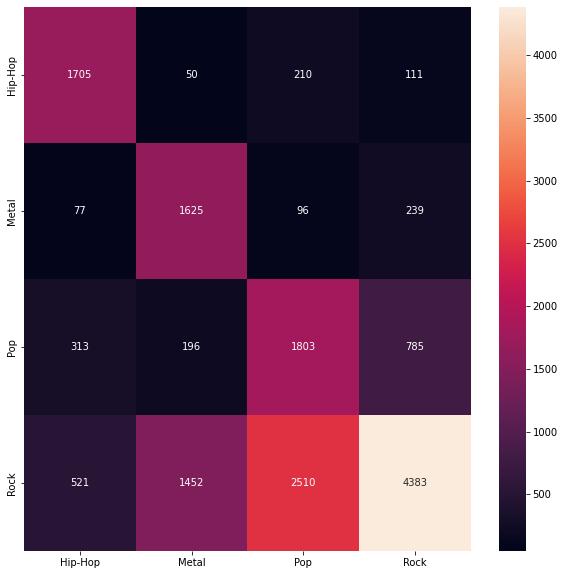

In [37]:
import seaborn as sn
from preprocessing.build_dataset import get_label_encoder 
labels = get_label_encoder("english_cleaned_lyrics.csv").classes_
df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)
plt.figure(figsize=(10, 10))
sn.heatmap(df_cm, annot=True, fmt="d")

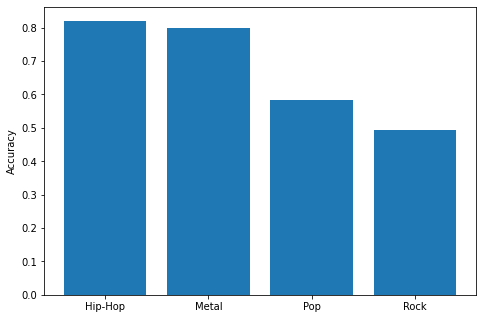

In [38]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

ax.bar(labels, conf_matrix.diagonal() / conf_matrix.sum(axis = 1))
plt.ylabel("Accuracy")
plt.show()

Text(0.5, 1.0, 'support')

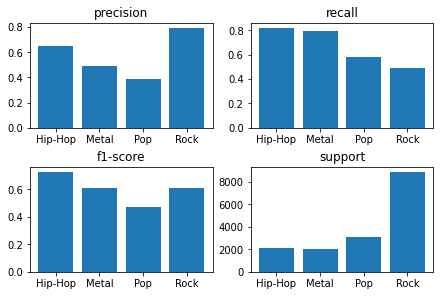

In [34]:
figure, axis = plt.subplots(2, 2, constrained_layout=True)
PRFS = ["precision", "recall", "f1-score", "support"]
axis[0, 0].bar(labels, prfs[0])
axis[0, 0].set_title(PRFS[0])
axis[0, 1].bar(labels, prfs[1])
axis[0, 1].set_title(PRFS[1])
axis[1, 0].bar(labels, prfs[2])
axis[1, 0].set_title(PRFS[2])
axis[1, 1].bar(labels, prfs[3])
axis[1, 1].set_title(PRFS[3])

In [35]:
print(prfs)

(array([0.65175841, 0.48901595, 0.39034423, 0.79430953]), array([0.82129094, 0.79774178, 0.5821763 , 0.49436048]), array([0.72676897, 0.60634328, 0.46734059, 0.60942714]), array([2076, 2037, 3097, 8866], dtype=int64))
